In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

sns.set()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')


In [90]:
df_initial = pd.read_csv('cleaned_df.csv')
df_line = df_initial.copy()
df_line['StockCode'] = df_line['StockCode'].astype('category')
df_line['InvoiceDate'] = df_line['InvoiceDate'].astype('datetime64[ns]')

# Customers Feature Engineering
We choose to classify customer by :
- money : how much money they spend : mean_basket
- frequency : how often they purchase : yearly frequency

I will keep only invoice lines with positive Quantity and will handle products returns (negative Quantity) separatly 


# Existing Customer classification

I wil create a customer DataFrame with one row per customer, aggregating informations from all purchases made by a customer. I will focus on : 
- money : mean amount of basket,
- frequency : I wil define frequency as nb of invoice/duration between the first customer invoice and the last day of the initial dataframe.    
- diversity of articles
- quantity per article
- Country   
- number of returned articles   


**TODO : insert information on :**
- Discount : has the customer benefitted from discounts ?
- preferred month : during which month has the customer most bought ? (max basket amount)

## Create the customer database and Feature Engineering

- The initial DataFrame has one row per article   
- The invoice DataFrame has one row per invoice   
- The customer DataFrame has one row per customer

In [91]:
def feature_engineering(df_line) :
    
    """
    df_line : original database, one row per invoice line
    df_invoice : df_line aggregation into one row per invoice
    df_customer : line and invoice agreggations into one row per customer
    """

    db_end = df_line['InvoiceDate'].max()

    # add amount for each line
    df_line['amount'] = df_line.UnitPrice*df_line.Quantity

    #agregate lines in invoices
    line_to_invoice_aggregations = {'CustomerID' : "first", 'amount' : "sum",'InvoiceDate' : 'first',
                         'StockCode' : 'size','Country': 'first'}
    
    df_invoice= df_line[df_line['Quantity']>0].groupby('InvoiceNo', as_index=False).agg(line_to_invoice_aggregations)

    # agregate invoice to customers

    invoice_to_customer_aggregations = {'amount' : ['sum','max', 'mean'],
                    'InvoiceDate' : ['min'],
                    'InvoiceNo' : 'count',
                    'StockCode' : ['max', 'mean'],
                    'Country' : 'first'}

    features_from_invoices = ['total_revenue', 'Basket_max', 'Basket_mean',
                 'First_purchase', 'Invoice_count',
                 'StockCode_max', 'StockCode_mean','Country']

    df_customer[features_from_invoices] = df_invoice.groupby('CustomerID').agg(invoice_to_customer_aggregations)

    # aggregate lines in customer
    line_to_customer_aggregations = {'StockCode' : 'size', 'Quantity' : ['min', 'max', 'mean']}

    features_from_lines = ['StockCode_size', 'Quantity_min', 'Quantity_max','Quantity_mean']

    df_customer[features_from_lines] = df_line[df_line['Quantity']>0].groupby('CustomerID').agg(line_to_customer_aggregations)

    ## others customer features
    # how long is it since first purchase, in days ?
    df_customer['anciennete'] = df_customer['First_purchase'].apply(lambda x : (db_end - x).total_seconds()/(60*60*24))
    
    #nb of purchased per month, based on 6 months
    df_customer['frequency'] = df_customer['Invoice_count'] /df_customer['anciennete']*365
    
    df_customer['annual_revenue'] = df_customer['frequency'] * df_customer['Basket_mean'] 
    
    # articles returned by customer, relative to customer recency
    df_customer['return_rate'] = -(df_line[df_line['Quantity']<0].groupby('CustomerID')['Quantity'].sum())*100/(df_line[df_line['Quantity']>0].groupby('CustomerID')['Quantity'].sum())
    df_customer['return_rate'] = df_customer['return_rate'].fillna(0) 
    
    # preferred month
    df_customer['preferred_month'] = df_invoice.groupby('CustomerID')['InvoiceDate'].apply(lambda x : int(str(x.dt.month.mode()[0])))
    df_customer['seasonality'] = df_invoice.groupby('CustomerID')['InvoiceDate'].apply(lambda x : x.dt.month.var())
    df_customer.seasonality = df_customer.seasonality.fillna(0)
    
 
    return df_customer

In [92]:
df_customer = pd.DataFrame()
df_customer = feature_engineering(df_line)

In [93]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4292 entries, 12347.0 to 18287.0
Data columns (total 18 columns):
total_revenue      4292 non-null float64
Basket_max         4292 non-null float64
Basket_mean        4292 non-null float64
First_purchase     4292 non-null datetime64[ns]
Invoice_count      4292 non-null int64
StockCode_max      4292 non-null int64
StockCode_mean     4292 non-null float64
Country            4292 non-null int64
StockCode_size     4292 non-null int64
Quantity_min       4292 non-null int64
Quantity_max       4292 non-null int64
Quantity_mean      4292 non-null float64
anciennete         4292 non-null float64
frequency          4292 non-null float64
annual_revenue     4292 non-null float64
return_rate        4292 non-null float64
preferred_month    4292 non-null int64
seasonality        4292 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(7)
memory usage: 637.1 KB


## Exploration

In [94]:
df_customer.describe(percentiles = [.99])

,total_revenue,Basket_max,Basket_mean,Invoice_count,StockCode_max,StockCode_mean,Country,StockCode_size,Quantity_min,Quantity_max,Quantity_mean,anciennete,frequency,annual_revenue,return_rate,preferred_month,seasonality
count,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000,4292.000
mean,1903.694,589.006,380.483,4.107,31.802,22.410,0.904,88.333,8.473,81.666,21.974,216.094,13.755,4695.829,1.682,6.473,6.485
std,8195.109,1294.439,506.980,7.352,30.976,20.934,0.294,216.069,101.395,220.477,118.546,116.441,126.819,24922.440,9.144,3.588,8.801
min,2.900,2.900,2.900,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.118,1.002,4.747,0.000,1.000,0.000
50%,653.030,363.650,292.044,2.000,23.000,17.000,1.000,40.000,1.000,36.000,10.000,243.070,5.556,1641.086,0.000,6.000,2.000
99%,16844.246,3847.744,2002.850,28.000,147.090,101.697,1.000,643.360,100.000,916.320,200.000,364.211,105.050,52896.243,36.369,12.000,40.500
max,267410.000,38970.000,14844.767,197.000,541.000,285.438,1.000,7368.000,4300.000,4800.000,4300.000,364.386,7200.000,1132296.988,327.586,12.000,60.500


**les clients achetent en moyene 13 fois par an**
**suppression des clients trop récents**

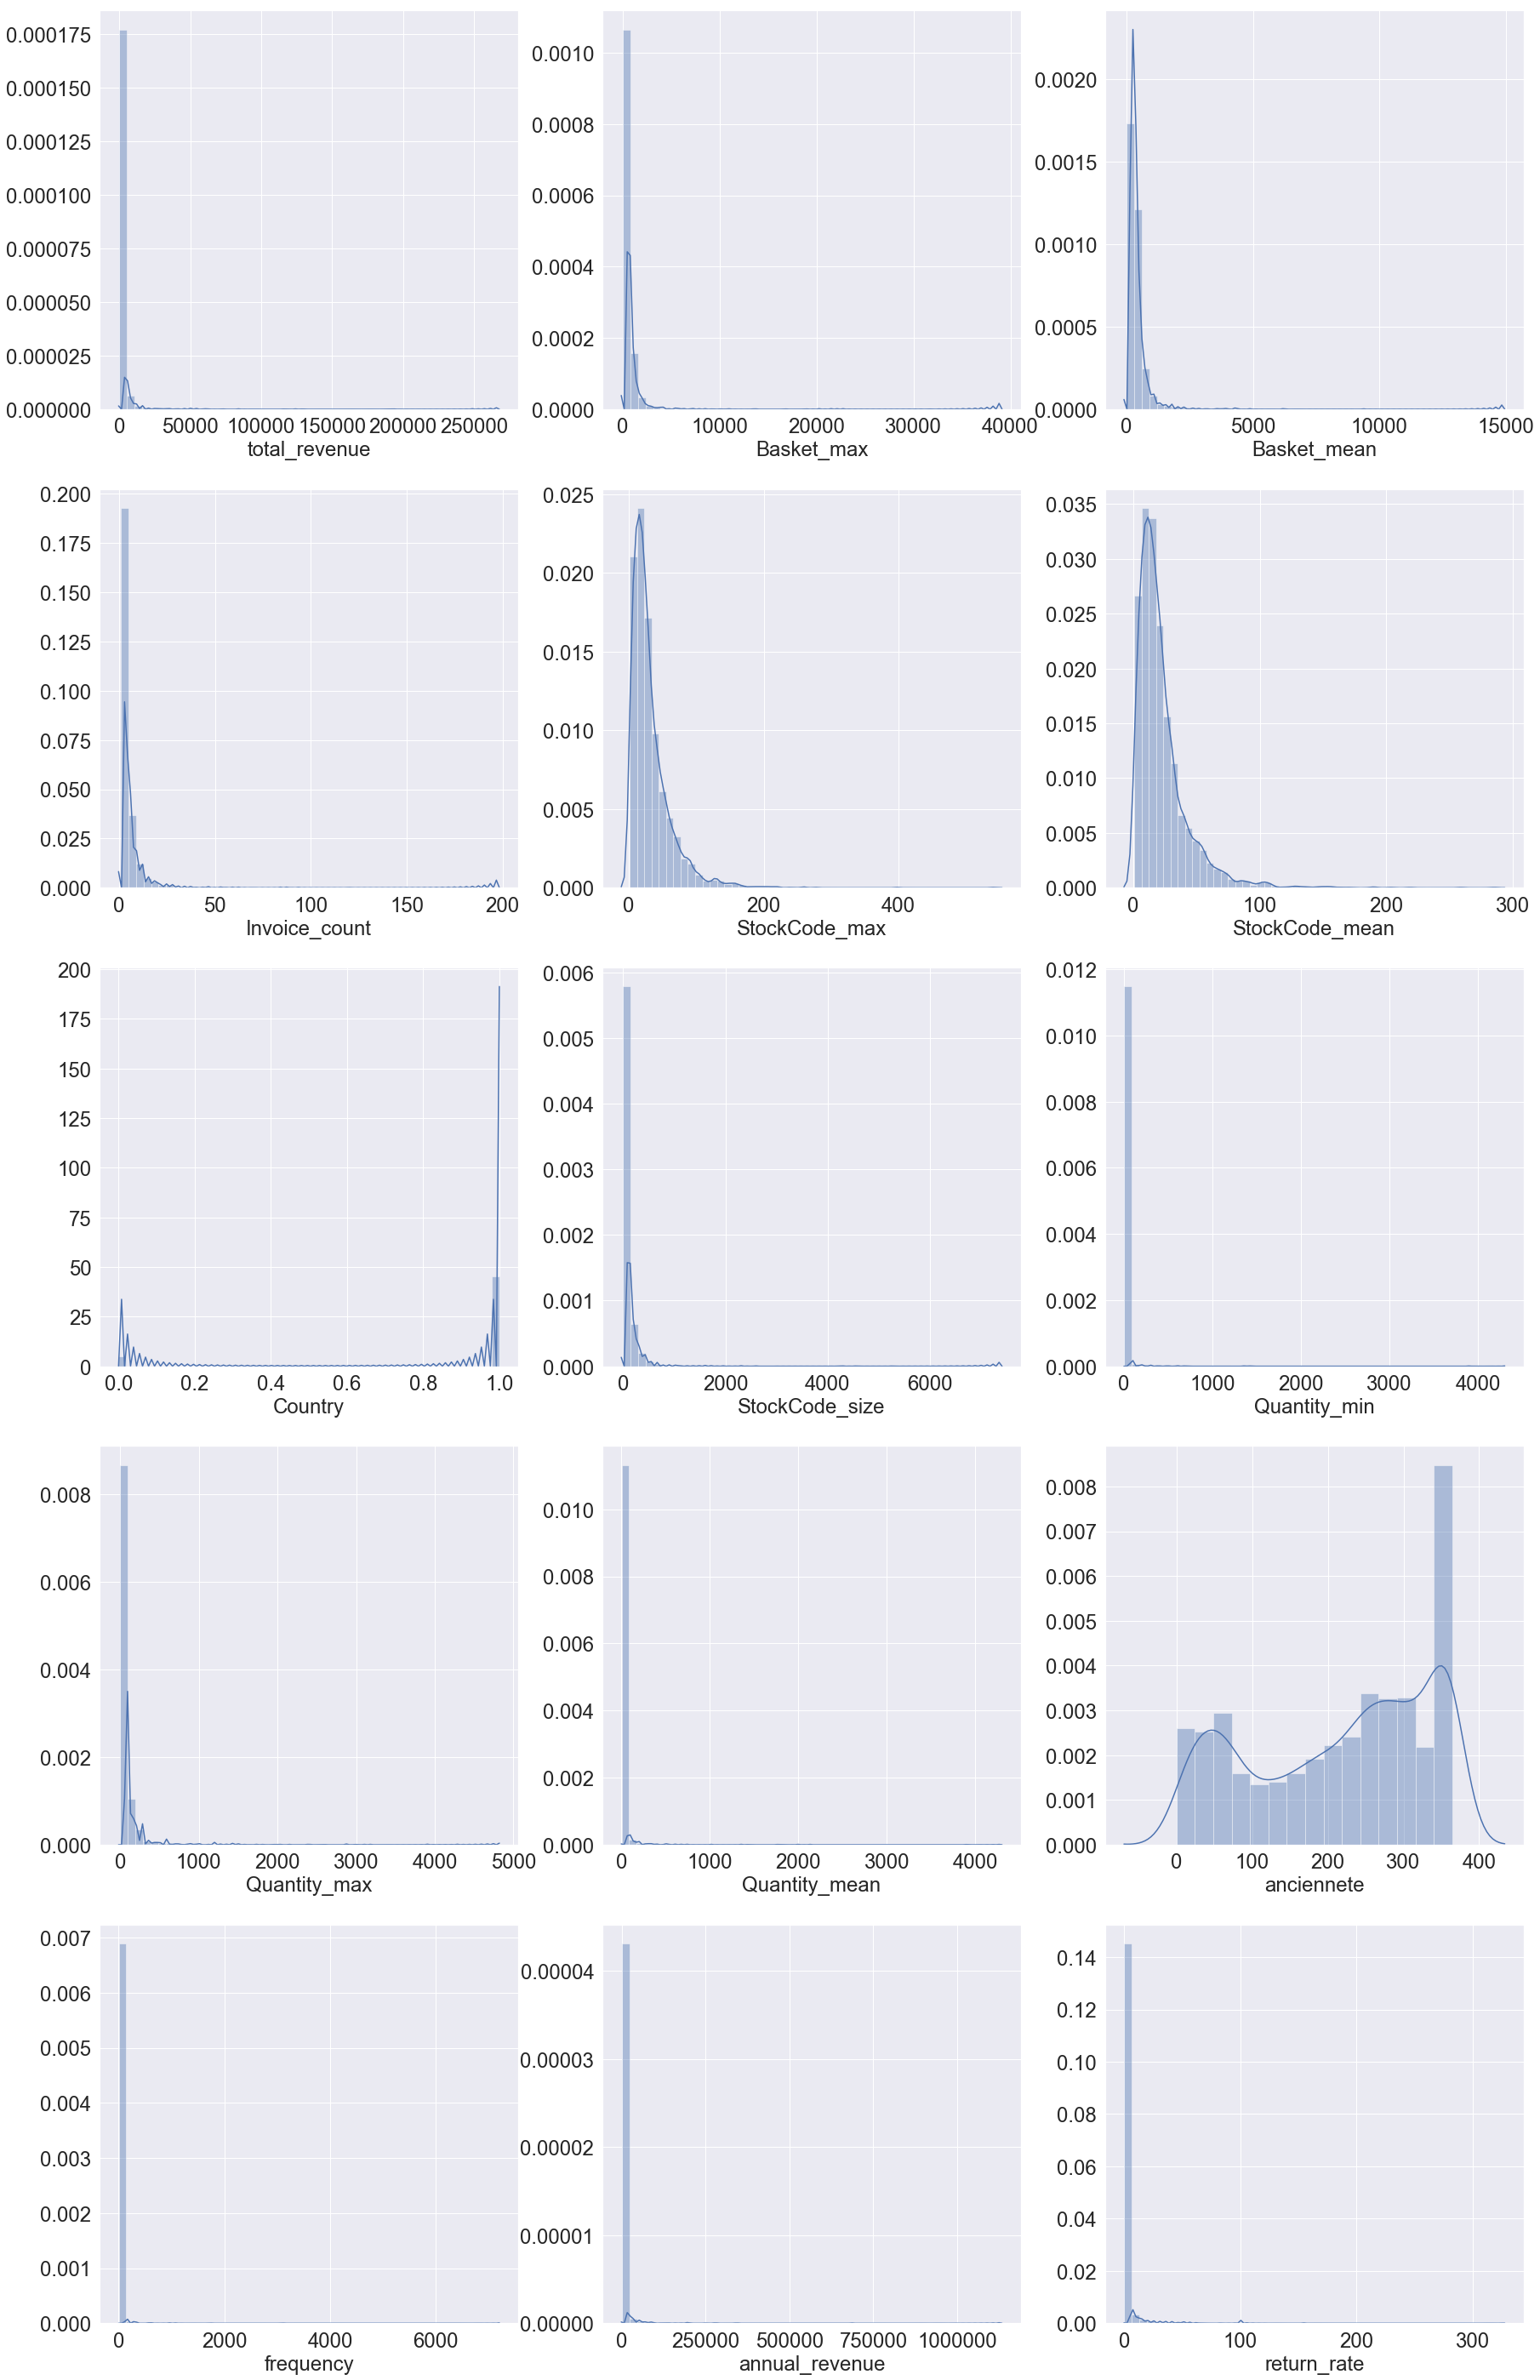

In [95]:
def display_subplot(data, plot_type) :
    columns = data.select_dtypes(include=[np.number]).columns.tolist()

    ncol = 3
    nrow = int((len(columns)/ncol)+0.1)

    fig, axs = plt.subplots(nrow, ncol, figsize=(10*ncol,10*nrow))
    
    for i, ax in enumerate(fig.axes) :
        if i<len(columns) :
            ax.set_xlabel('', fontsize=24)
            
            ax.tick_params(labelsize=24)
            if plot_type == 'kde' :
                ax.set_title(columns[i], fontsize=24)
                sns.kdeplot(data=data[columns[i]],ax=ax)

            elif plot_type == 'dist' :
                sns.distplot(data[columns[i]],ax=ax)
                    
        
            
display_subplot(df_customer, 'dist')


## Outliers

In [96]:
def vizualise_upper_outliers(df, quantile, columns = 'all numeric') :
    
    #select numeric columns
    if columns =='all numeric' : columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    df_outliers = pd.DataFrame(columns = columns + ['outlier'])

    for col in columns :
        threshold = df[col].quantile(quantile)
        df_new_lines = pd.DataFrame()
        df_new_lines = df[df[col] > threshold]
        df_new_lines['outlier'] = col
        df_outliers = df_outliers.append(df_new_lines[df_outliers.columns])
        
    print('number of outliers per variable : ')
    print(df_outliers['outlier'].value_counts())
    print("total nb of outliers : {}".format(df_outliers.index.nunique()))
    
    outliers_index = df_outliers.index.drop_duplicates()
    df_unique_outliers = df_outliers.loc[outliers_index]
    
    return df_unique_outliers


In [97]:
#numeric columns
columns = df_customer.select_dtypes(include=[np.number]).columns.tolist()

#exclude UK variable for outliers search
columns = [col for col in columns if col not in(['UK', 'preferred_month'])]

outliers = vizualise_upper_outliers(df_customer, .999, columns)

number of outliers per variable : 
Quantity_min      5
anciennete        5
StockCode_size    5
Quantity_mean     5
frequency         5
total_revenue     5
Basket_max        5
Quantity_max      5
StockCode_max     5
annual_revenue    5
StockCode_mean    5
Basket_mean       5
Invoice_count     4
return_rate       2
Name: outlier, dtype: int64
total nb of outliers : 41


In [98]:
def exclude_upper_outliers(df, quantile, columns = 'all numeric') :
    df_outliers = vizualise_upper_outliers(df_customer, .999, columns)
    # ~ = negation of the condition
    return df[~df.index.isin(df_outliers.index)]
   

In [99]:
df_customer = exclude_upper_outliers(df_customer, .999, columns)
df_customer.shape

number of outliers per variable : 
Quantity_min      5
anciennete        5
StockCode_size    5
Quantity_mean     5
frequency         5
total_revenue     5
Basket_max        5
Quantity_max      5
StockCode_max     5
annual_revenue    5
StockCode_mean    5
Basket_mean       5
Invoice_count     4
return_rate       2
Name: outlier, dtype: int64
total nb of outliers : 41


(4251, 18)

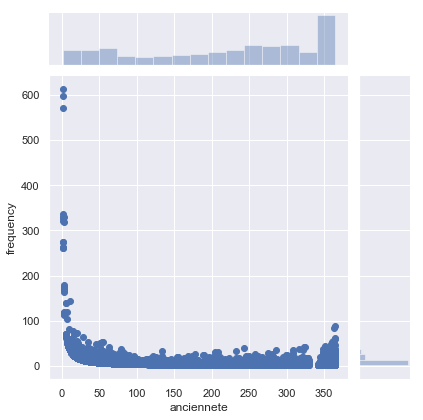

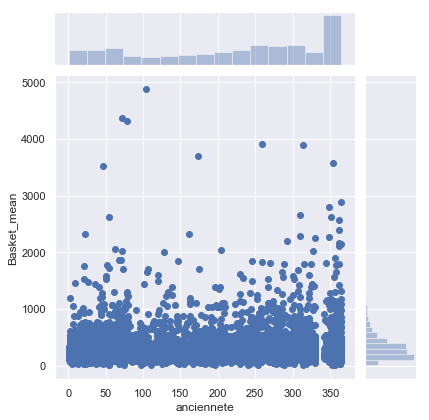

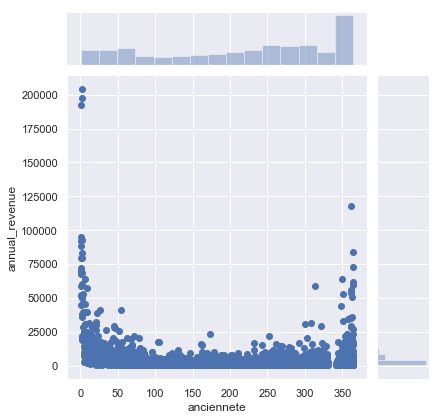

In [100]:
sns.jointplot(x = df_customer['anciennete'], y = df_customer['frequency'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['Basket_mean'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['annual_revenue'])


**pic à droite sur les acheteurs de noel, retirons les acheteurs de Noël**

In [101]:
df_customer = df_customer[(df_customer['anciennete']>200) & (df_customer['anciennete']<340)]

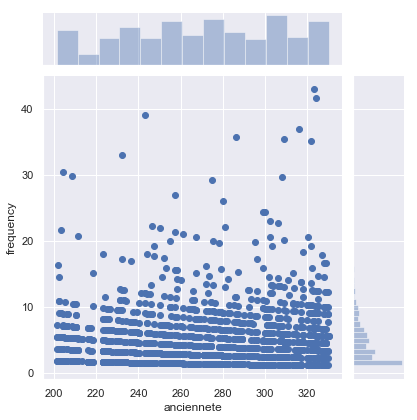

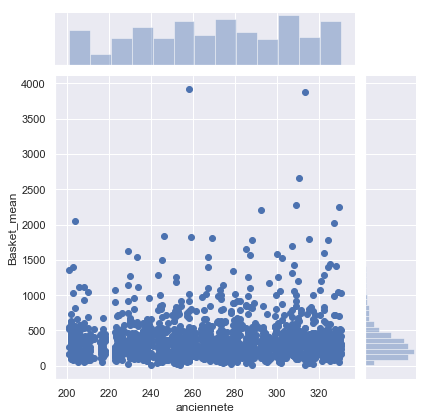

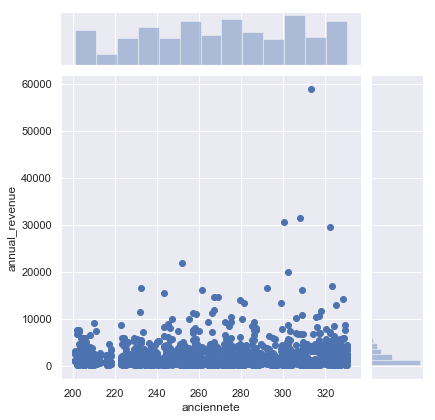

In [102]:
sns.jointplot(x = df_customer['anciennete'], y = df_customer['frequency'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['Basket_mean'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['annual_revenue'])

## Standardisation

In [103]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler

#scl = Normalizer()
scl = MaxAbsScaler()

numeric_columns = ['total_revenue', 'annual_revenue', 'Basket_max', 'Basket_mean',
       'Invoice_count', 'StockCode_max', 'StockCode_mean','StockCode_size', 'Quantity_min',
       'Quantity_max', 'Quantity_mean', 'anciennete', 'frequency', 'return_rate', 'preferred_month']

df_customer[numeric_columns] = scl.fit_transform(df_customer[numeric_columns])


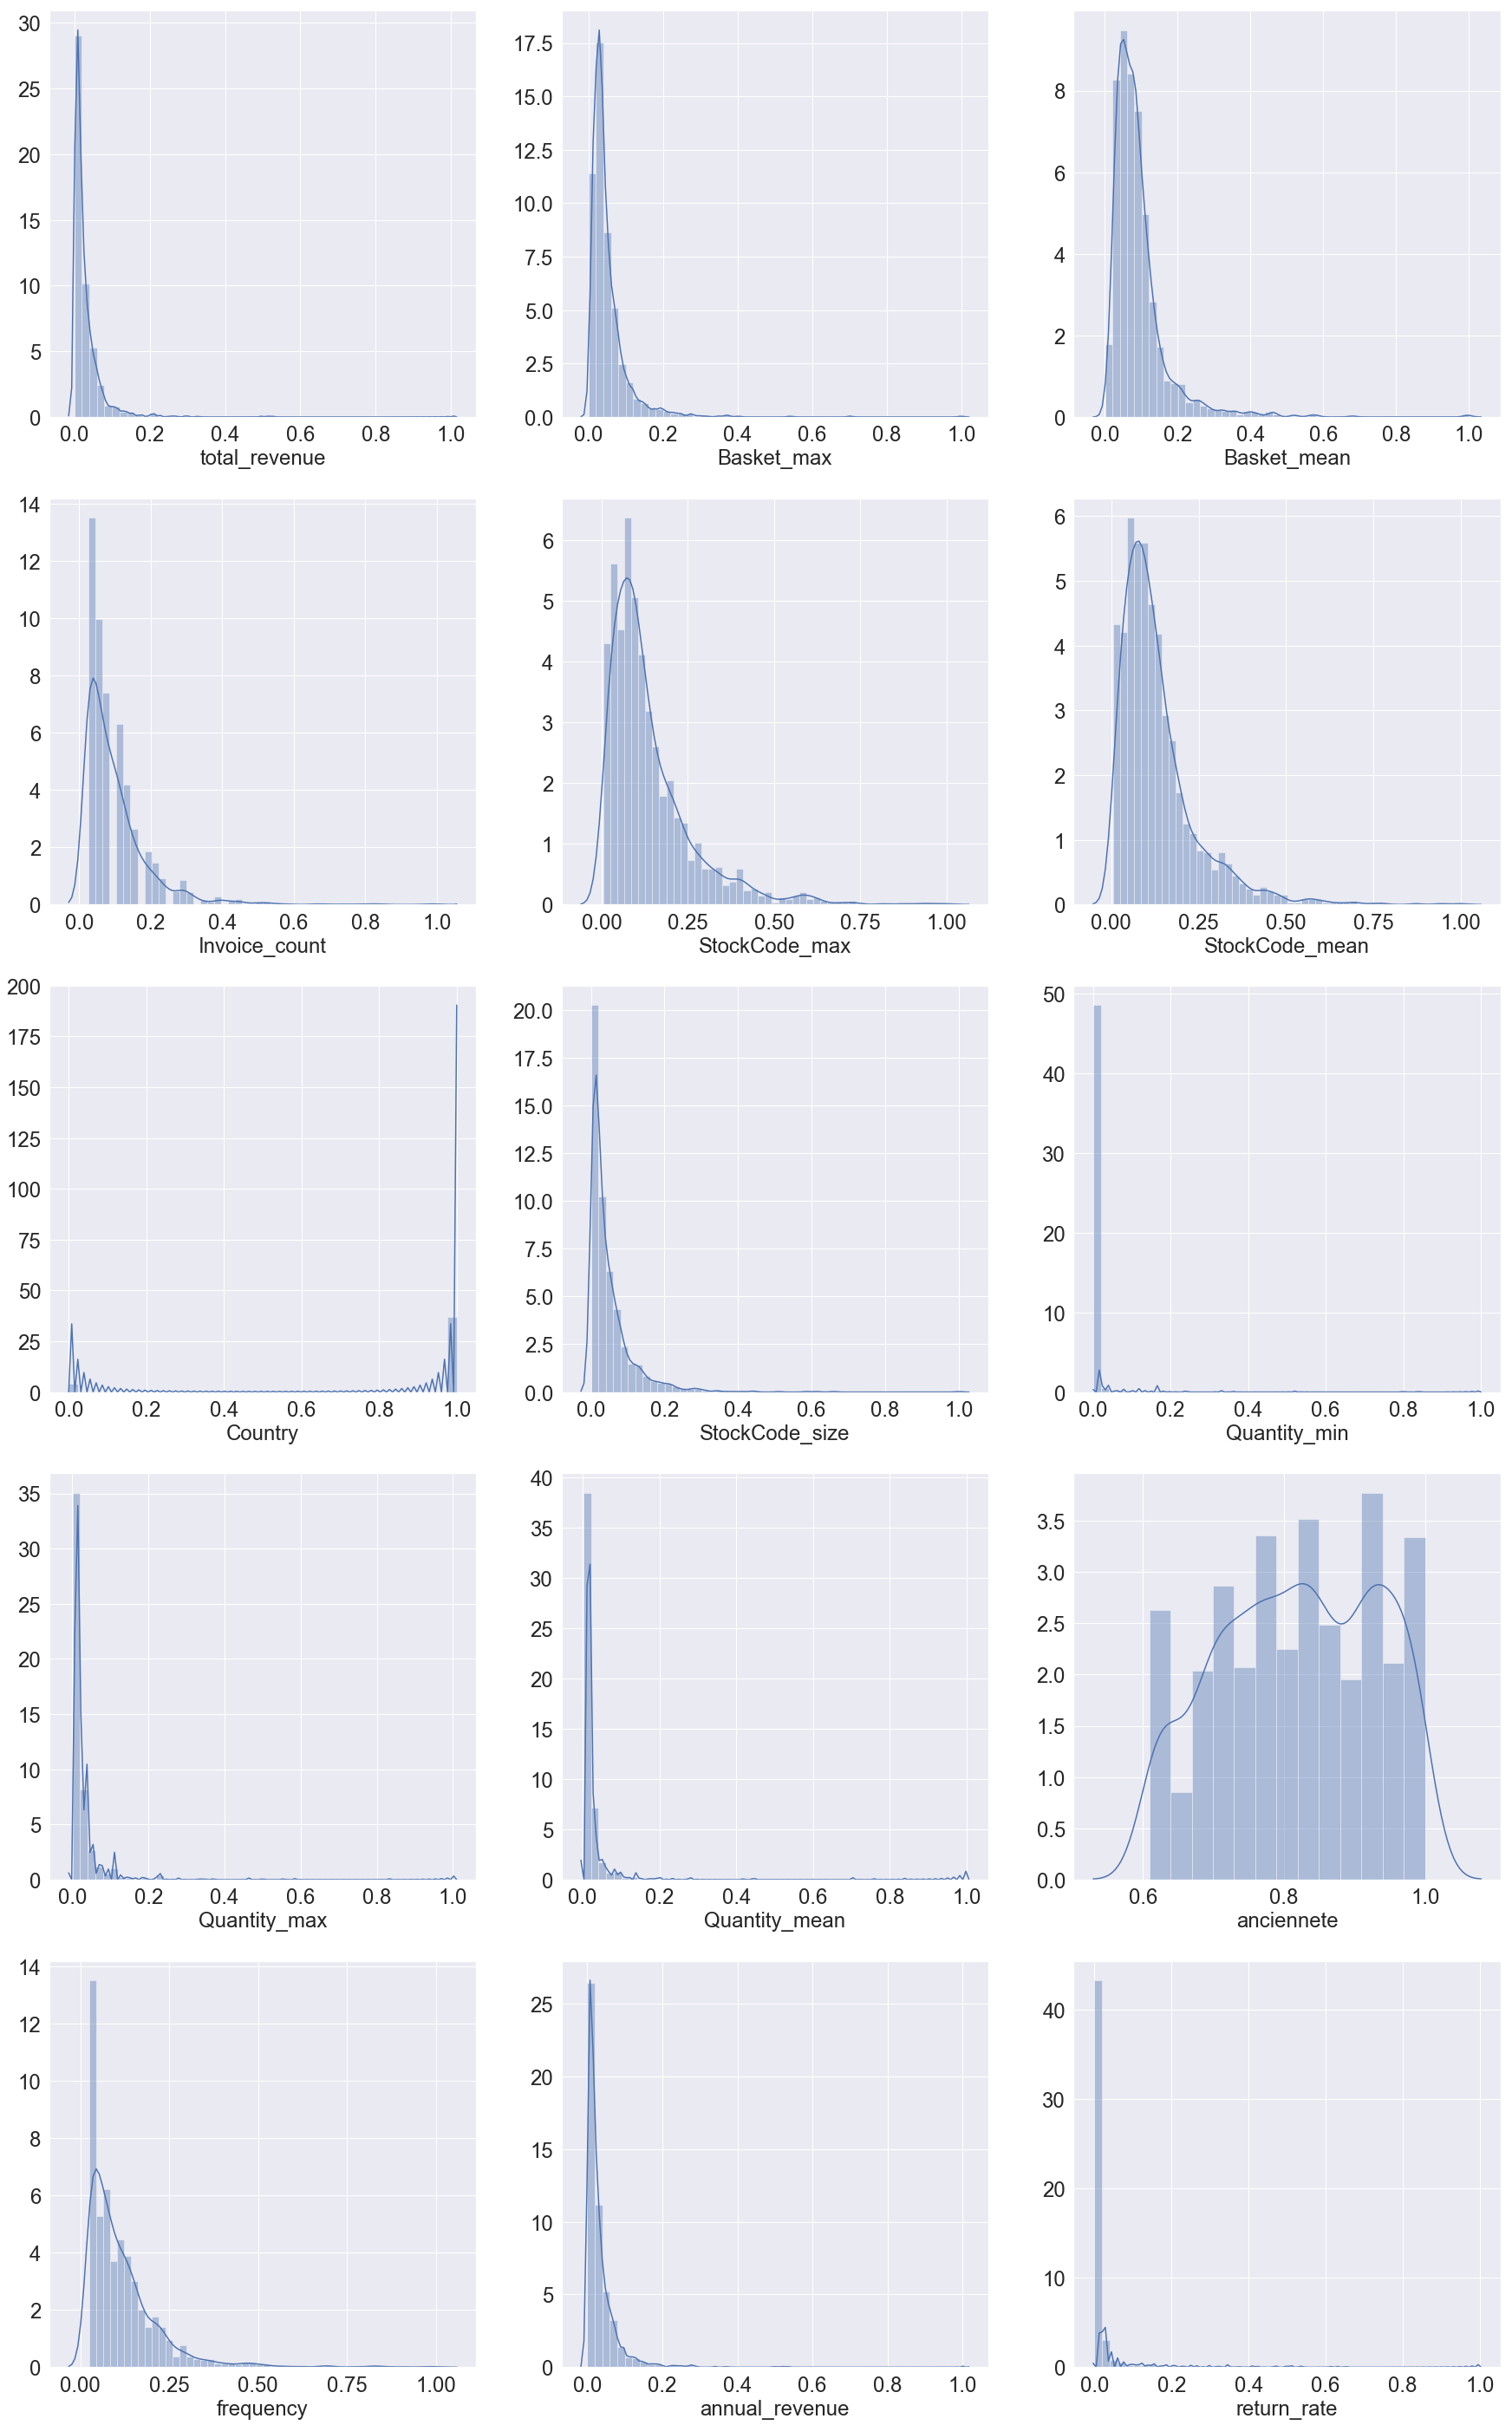

In [104]:
display_subplot(df_customer, 'dist')

In [105]:
df_customer.describe()

,total_revenue,Basket_max,Basket_mean,Invoice_count,StockCode_max,StockCode_mean,Country,StockCode_size,Quantity_min,Quantity_max,Quantity_mean,anciennete,frequency,annual_revenue,return_rate,preferred_month,seasonality
count,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000,1683.000
mean,0.029,0.051,0.092,0.100,0.139,0.132,0.900,0.050,0.008,0.028,0.023,0.819,0.119,0.033,0.017,0.345,8.604
std,0.047,0.055,0.079,0.096,0.125,0.112,0.300,0.067,0.045,0.054,0.053,0.111,0.109,0.050,0.069,0.243,8.960
min,0.000,0.000,0.001,0.026,0.005,0.006,0.000,0.001,0.002,0.000,0.001,0.609,0.026,0.000,0.000,0.091,0.000
25%,0.007,0.022,0.046,0.026,0.059,0.059,1.000,0.012,0.002,0.009,0.009,0.727,0.041,0.008,0.000,0.182,0.000
50%,0.016,0.035,0.076,0.079,0.104,0.103,1.000,0.028,0.002,0.014,0.014,0.824,0.086,0.019,0.000,0.273,7.659
75%,0.035,0.060,0.108,0.132,0.180,0.168,1.000,0.064,0.003,0.028,0.020,0.915,0.151,0.040,0.006,0.455,12.569
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,50.000


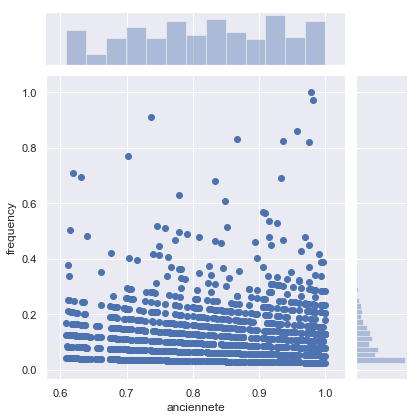

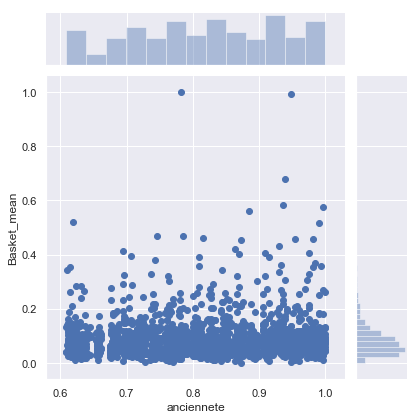

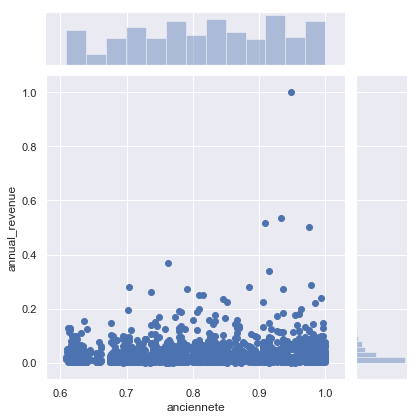

In [106]:
sns.jointplot(x = df_customer['anciennete'], y = df_customer['frequency'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['Basket_mean'])
sns.jointplot(x = df_customer['anciennete'], y = df_customer['annual_revenue'])

## Exploration

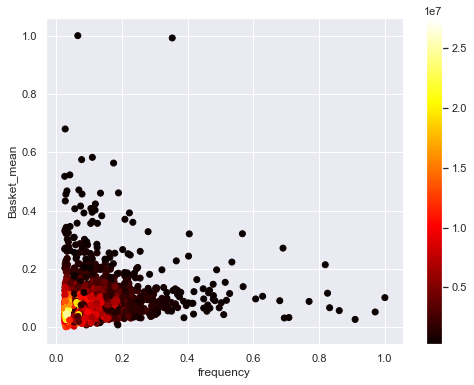

In [107]:
import matplotlib 
from matplotlib import cm
from scipy import stats
data=df_customer[['frequency', 'Basket_mean', 'seasonality', 'preferred_month', 'anciennete']]



values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

data['density'] = density
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

colmap = matplotlib.cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(data[['density']]*1000000)

ax.scatter(data['frequency'], data['Basket_mean'], c=data['density']*1000000, cmap='hot')
cb = fig.colorbar(colmap)

ax.set_xlabel('frequency');
ax.set_ylabel('Basket_mean');
plt.show()



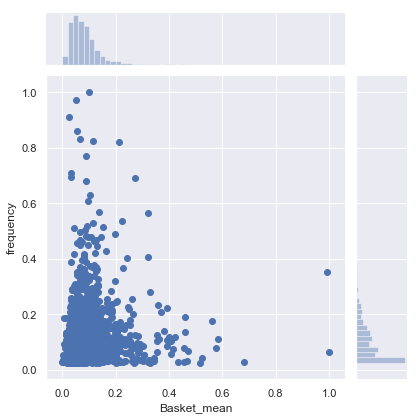

In [108]:
sns.jointplot(x = data['Basket_mean'], y = data['frequency'])

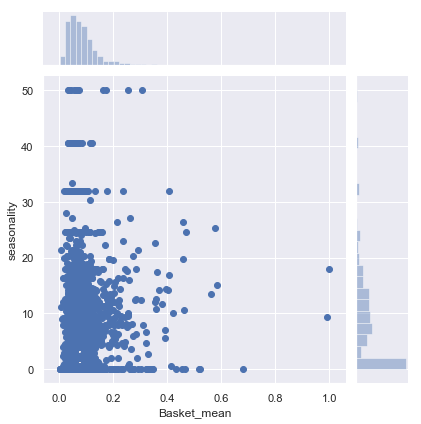

In [20]:
sns.jointplot(x = data['Basket_mean'], y = data['seasonality'])

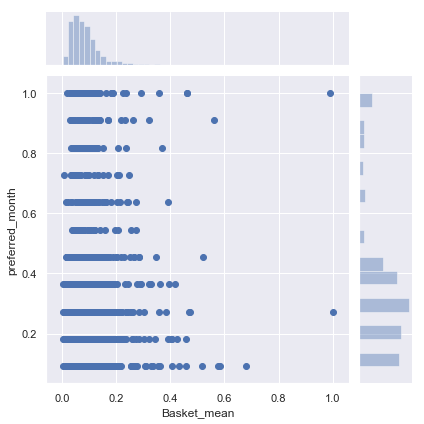

In [21]:
sns.jointplot(x = data['Basket_mean'], y = data['preferred_month'])

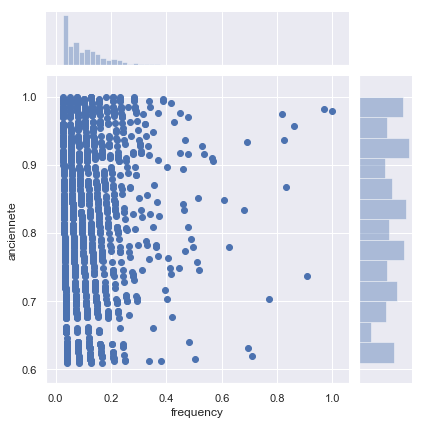

In [22]:
sns.jointplot(x = data['frequency'], y = data['anciennete'])

## Classification 

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import math

def clustering_results(df_cluster, df_customer,features, fig_columns, n_clusters) :
    cls = KMeans(n_clusters)
    cls.fit(df_cluster[features])
    labels, counts = np.unique(cls.labels_, return_counts=True)
    
    ax = sns.barplot(x = labels, y = counts)
    ax.set_title('taille des clusters', fontsize=24)
    
    
    ncol = 3
    #round up
    nrow = math.ceil(len(fig_columns)/ncol)

    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*10))
    for i, ax in enumerate(fig.axes) :
        if i < len(fig_columns) :
            ax.set_xlabel('', fontsize=24)
            ax.set_title(fig_columns[i], fontsize=24)
            ax.tick_params(labelsize=24)
            sns.boxplot(y=fig_columns[i],x=cls.labels_,hue=cls.labels_,data=df_customer[fig_columns],showfliers=False,ax=ax)
            
    return cls        


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

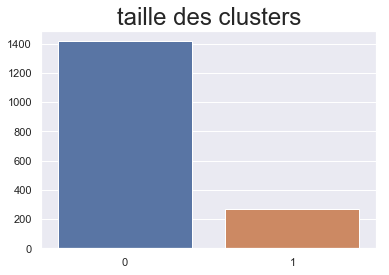

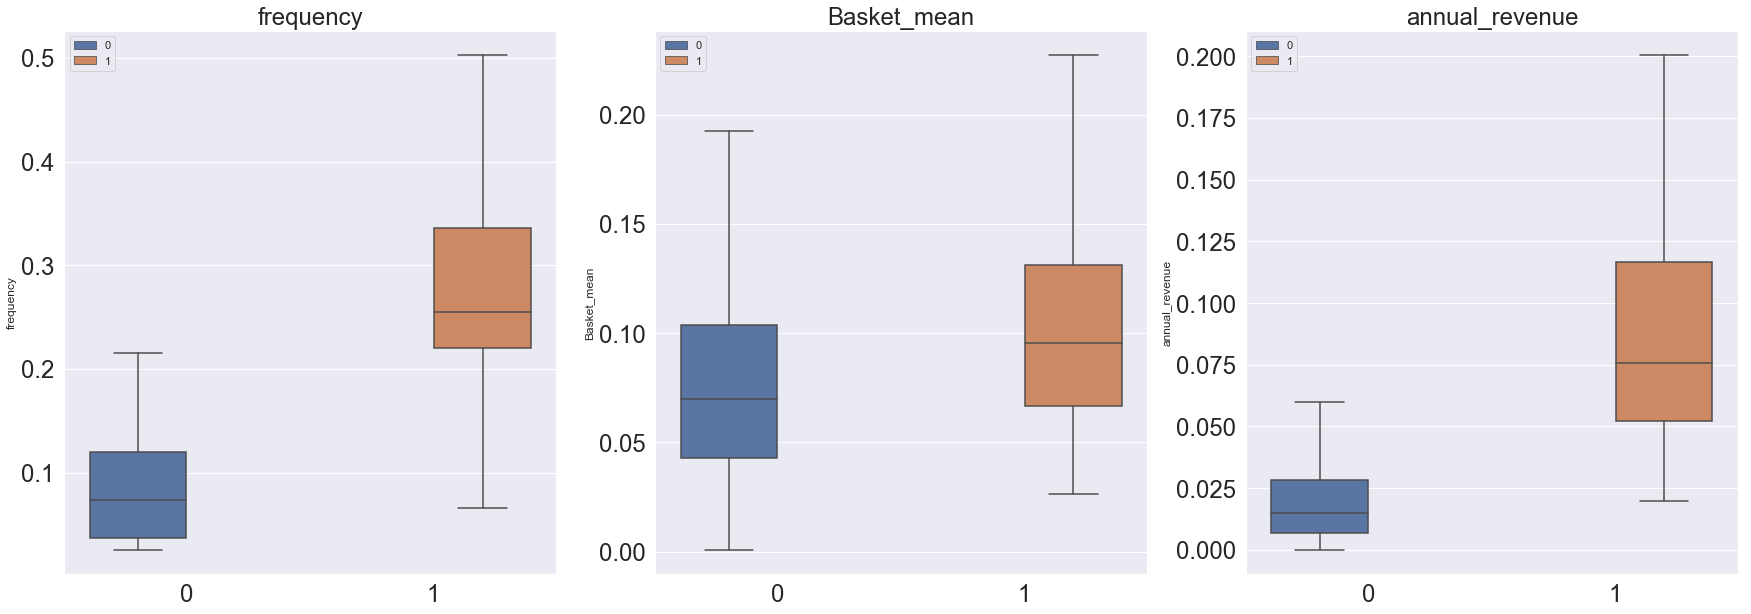

In [24]:
clustering_results(df_customer, df_customer,['frequency', 'annual_revenue','Basket_mean'], ['frequency','Basket_mean', 'annual_revenue'], 2)

In [25]:
df_customer[['total_revenue', 'Basket_max', 'Basket_mean',
       'Invoice_count', 'StockCode_max', 'StockCode_mean','StockCode_size', 'Quantity_min',
       'Quantity_max', 'Quantity_mean', 'anciennete', 'frequency', 'return_rate']].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1683 entries, 12350.0 to 18283.0
Data columns (total 13 columns):
total_revenue     1683 non-null float64
Basket_max        1683 non-null float64
Basket_mean       1683 non-null float64
Invoice_count     1683 non-null float64
StockCode_max     1683 non-null float64
StockCode_mean    1683 non-null float64
StockCode_size    1683 non-null float64
Quantity_min      1683 non-null float64
Quantity_max      1683 non-null float64
Quantity_mean     1683 non-null float64
anciennete        1683 non-null float64
frequency         1683 non-null float64
return_rate       1683 non-null float64
dtypes: float64(13)
memory usage: 184.1 KB


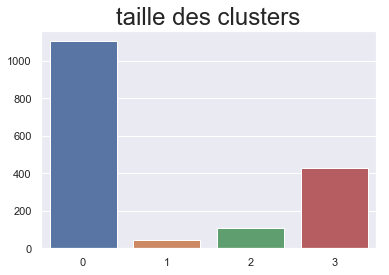

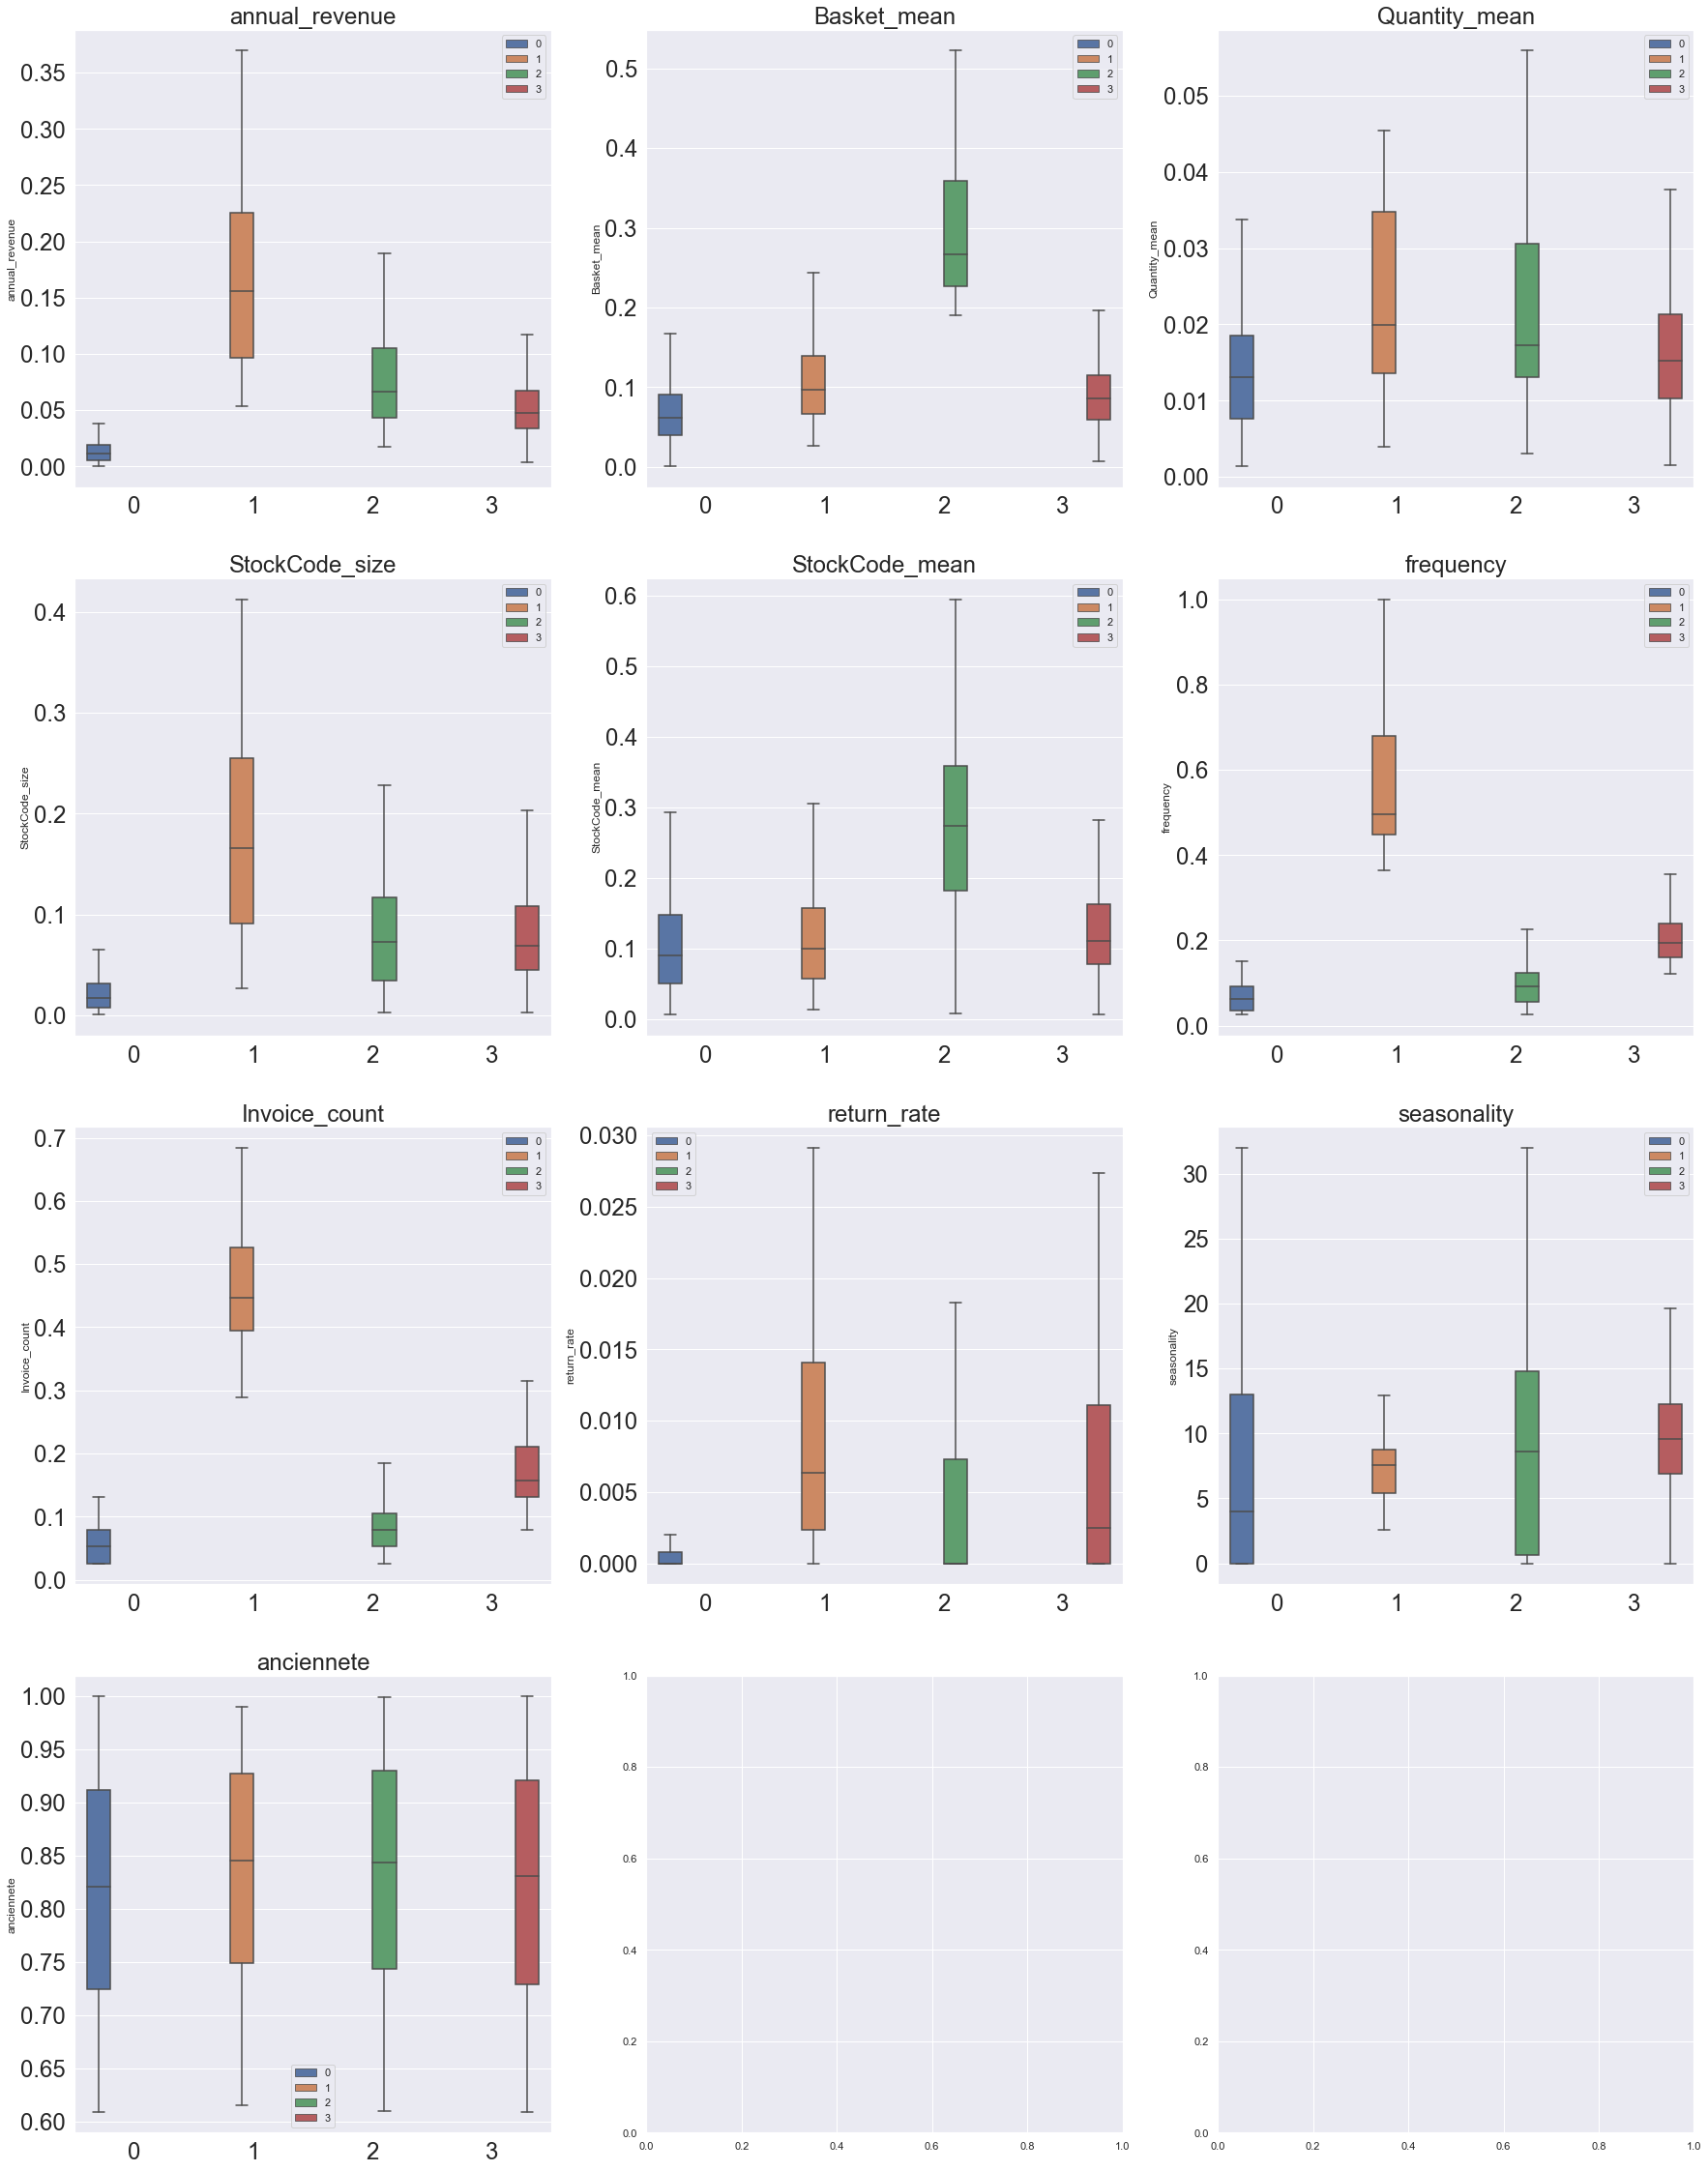

In [26]:
features = ['annual_revenue', 'Basket_mean','Quantity_mean',
       'StockCode_size', 'StockCode_mean', 'frequency', 'Invoice_count','return_rate', 'seasonality']
coeffs=dict()
coeff = {'annual_revenue' : 1, 'Basket_mean' : 1,'Quantity_mean' : 0,
       'StockCode_size' : 0, 'StockCode_mean' : 0,'frequency' : 1, 'Invoice_count': 0, 'return_rate' : 0, 'seasonality' : 0}
         
df_cluster = pd.DataFrame()
for f in features :
    df_cluster[f] = df_customer[f] * coeff[f]
    
cls2 = clustering_results(df_cluster,df_customer,['annual_revenue', 'Basket_mean','Quantity_mean',
   'StockCode_size', 'StockCode_mean', 'frequency',  'Invoice_count', 'return_rate', 'seasonality'], ['annual_revenue', 'Basket_mean','Quantity_mean',
   'StockCode_size', 'StockCode_mean', 'frequency',  'Invoice_count', 'return_rate', 'seasonality', 'anciennete'], 4)

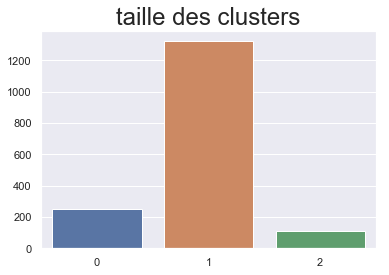

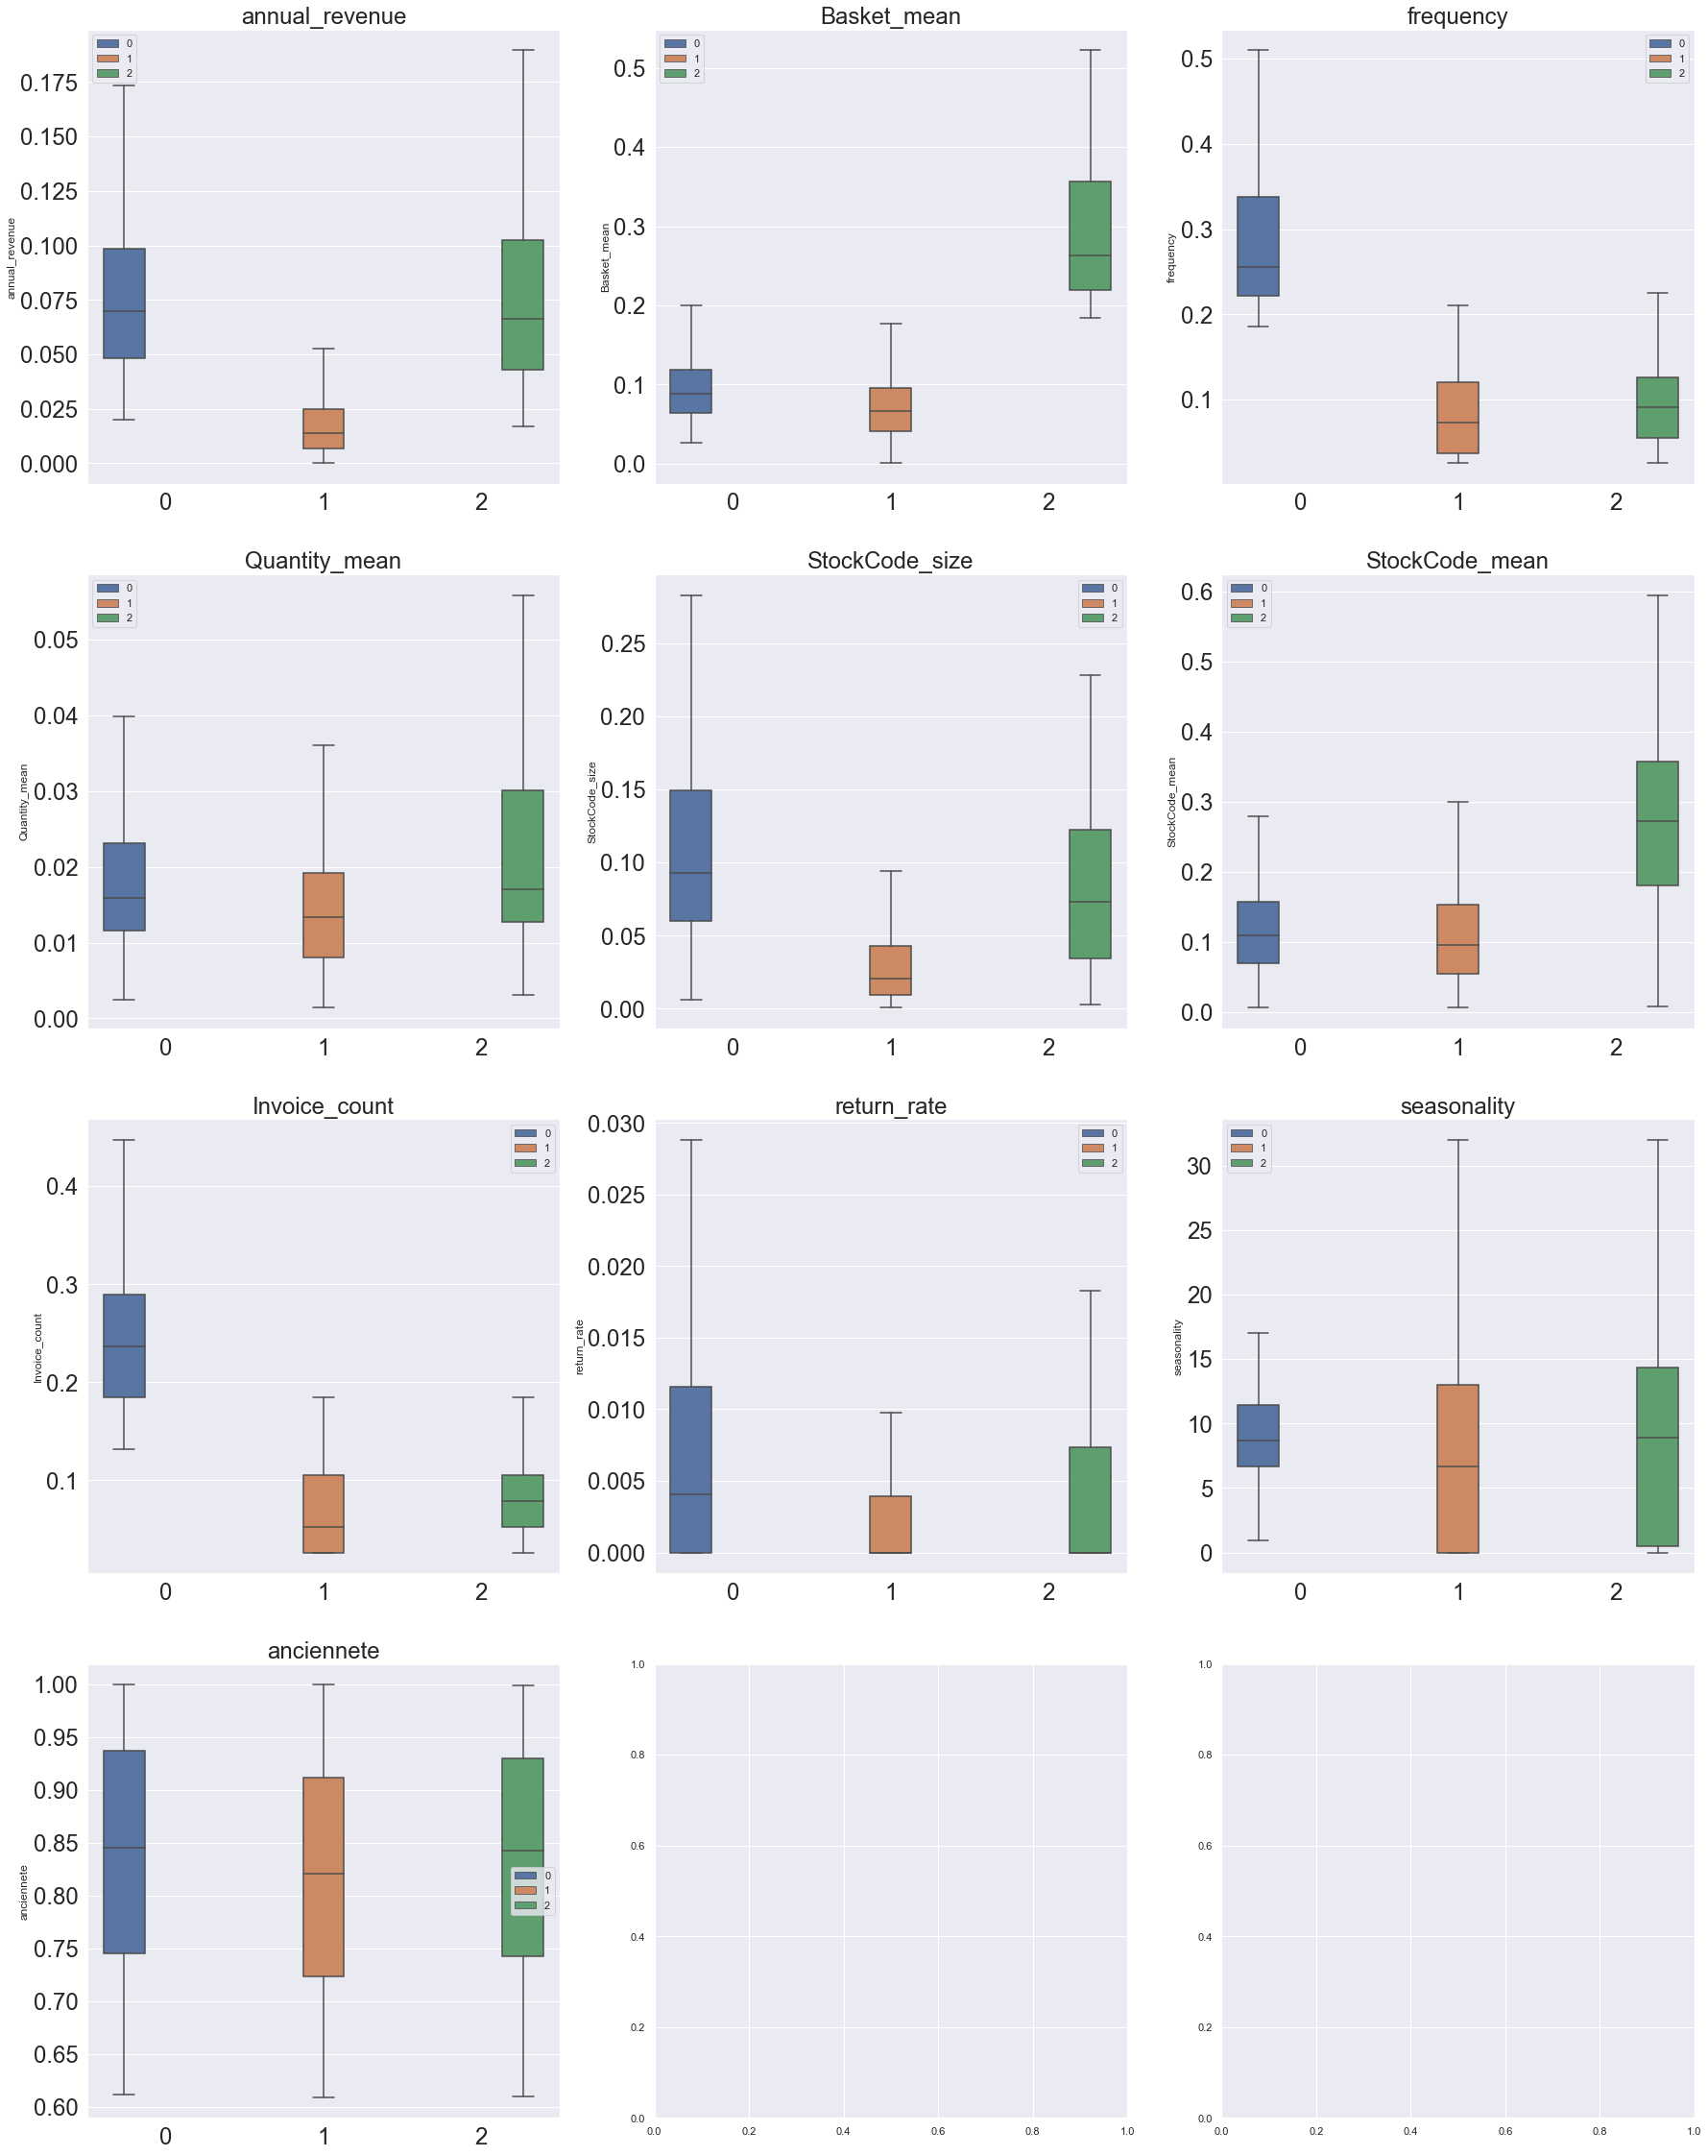

In [27]:
features = ['annual_revenue', 'Basket_mean','Quantity_mean',
       'StockCode_size', 'StockCode_mean', 'frequency', 'Invoice_count','return_rate', 'seasonality']
coeffs=dict()
coeff = {'annual_revenue' : 1, 'Basket_mean' : 1,'Quantity_mean' :0,
       'StockCode_size' : 0, 'StockCode_mean' : 0,'frequency' : 1, 'Invoice_count': 0, 'return_rate' : 0, 'seasonality' : 0}
         
df_cluster = pd.DataFrame()
for f in features :
    df_cluster[f] = df_customer[f] * coeff[f]
    
cls = clustering_results(df_cluster,df_customer,['annual_revenue', 'Basket_mean','Quantity_mean',
   'StockCode_size', 'StockCode_mean', 'frequency',  'Invoice_count', 'return_rate', 'seasonality'], ['annual_revenue', 'Basket_mean', 'frequency','Quantity_mean',
   'StockCode_size', 'StockCode_mean',  'Invoice_count', 'return_rate', 'seasonality', 'anciennete'], 3)

## Chosen Classification = Kmeans with 3 clusters

In [28]:
df_customer['group'] = cls.labels_

In [29]:
df_customer['group'].describe()

count   1683.000
mean       0.916
std        0.455
min        0.000
25%        1.000
50%        1.000
75%        1.000
max        2.000
Name: group, dtype: float64

In [30]:
df_customer.index

Float64Index([12350.0, 12352.0, 12354.0, 12355.0, 12356.0, 12359.0, 12361.0,
              12362.0, 12363.0, 12365.0,
              ...
              18242.0, 18246.0, 18250.0, 18257.0, 18263.0, 18270.0, 18272.0,
              18273.0, 18280.0, 18283.0],
             dtype='float64', name='CustomerID', length=1683)

# Predict customer classification at first purchase
at first purchase, all we know is the customer basket :
- basket amount   
- number of differents items    
- mean number of items   
- products   

Since only one year of transactions is covered by our database, we cannot know when an invoice is a first invoice for a customer. 

Therefore we will train our classification model on all invoices.

The label target is the customer group. For each new invoice , we want to predict the group of the invoice customer.



## Train and test splitting

we will sample 70% of the InvoiceNo for trainning and 30% for testing

In [31]:
from sklearn.model_selection import train_test_split

df_line = df_initial[df_initial['Quantity']>0].copy()

customer_list = df_line['CustomerID'].unique()
customer_train,customer_test = train_test_split(customer_list, random_state=42)

In [32]:
df_line['Quantity'] = df_line['Quantity'].astype('float64')
df_line = df_line.join(df_customer[['group']], on=['CustomerID'])

X_train = df_line[df_line['CustomerID'].isin(customer_train)]
X_train = X_train.dropna(subset=['group'])
y_train = X_train.groupby(['InvoiceNo'])['group'].first()
X_train = X_train.drop(columns=(['group']))


X_test = df_line[df_line['CustomerID'].isin(customer_test)]
X_test = X_test.dropna(subset=['group'])
y_test = X_test.groupby(['InvoiceNo'])['group'].first()
X_test = X_test.drop(columns=(['group']))


# handle unbalanced class
unique, counts = np.unique(y_train, return_counts=True)
class_weights = dict(zip(unique, counts))


## Preprocessing

In [33]:
X_train[0:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,548212,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,12.000,2011-03-30 09:12:00,1.250,12456.000,0
1,564034,22960,JAM MAKING SET WITH JARS,6.000,2011-08-22 12:22:00,4.250,12935.000,1
4,565223,23245,SET OF 3 REGENCY CAKE TINS,4.000,2011-09-01 19:08:00,4.950,15410.000,1
9,543371,72807C,SET/3 VANILLA SCENTED CANDLE IN BOX,1.000,2011-02-07 14:53:00,4.250,14048.000,1
10,565865,21680,WOODLAND STICKERS,12.000,2011-09-07 15:07:00,0.850,12637.000,0


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# does nothing, but is here to collect numerical columns
class nothing(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):       
        
        return self
    
    def transform(self, X):          
    
        return X
    
    
class Aggregator(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)       

        X = X.rename(columns = {0 :'InvoiceNo', 1:'Quantity', 2:'UnitPrice',3:'CustomerID' })
        X['amount'] = X.UnitPrice*X.Quantity
        X['InvoiceNo'] =  X['InvoiceNo'].astype('float64')
        X['InvoiceNo'] =  X['InvoiceNo'].astype('int')
        X['Quantity'] = X['Quantity'].astype('float64')
        X['UnitPrice'] = X['UnitPrice'].astype('float64')
        aggregations = dict()
        for col in range(4, X.shape[1]-1) : # 'amount' is the last column
            aggregations[col] = 'first'

        aggregations.update({ 'CustomerID' : 'first','amount' : 'sum','Quantity' : 'mean', 'UnitPrice' : 'mean'})

        # aggregating all basket lines
        result = X.groupby('InvoiceNo').agg(aggregations)


        # add number of lines in the basket
        result['lines_nb'] = X.groupby('InvoiceNo').size()

        return result



In [35]:
numeric_features = ['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']
#numeric_transformer = Pipeline(steps=[('nothing', nothing())])
categorical_features = ['StockCode', 'Country']

n_features = 100

encoder =  ColumnTransformer(
    [
        # 'num' transformer does nothing, but is here to collect numerical colums
        ('num', nothing() ,numeric_features ),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ('best', TruncatedSVD(n_components=n_features)),
         ]), categorical_features)        
    ]
)
                          
# define preprocessing steps
preproc_steps = [('encoder', encoder),
                 ('aggregator', Aggregator()) ]


In [36]:
X_train_preprocessed = Pipeline(preproc_steps).fit_transform(X_train)

In [37]:
from joblib import dump, load
dump(Pipeline(preproc_steps), 'preproc.joblib') 

['preproc.joblib']

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier



# specification of different model types and their defaults
model_dict = {'lr': LogisticRegression(C=0.001, penalty='l2', tol=0.01,
                                                     class_weight=class_weights),
                   'rf': RandomForestClassifier(n_estimators=400, max_features='auto',
                                                       class_weight=class_weights),
                   'gbc': GradientBoostingClassifier(n_estimators=400, max_depth=3),
                   'xgb': XGBClassifier(scale_pos_weight=class_weights[1],
                                                 n_estimators=100, max_depth=4),
                   'dummy': DummyClassifier(strategy='most_frequent')
                   }


# specification of the different model hyperparameters and tuning space
model_params_grid = {'lr': {'C': [1e-4, 1e-3, 1e-2, 1e-1]},
                    'rf': {
                           # 'rf__max_features': [3, n_features, np.sqrt(n_features)],
                           #'n_estimators': [10, 100, 1000]
                    },
                     'gbc': {'n_estimators': [100, 200]},
                     'xgb': {
                             #'max_depth': [9, 12],
                             #'reg_alpha': [15, 20],
                             #'reg_lambda': [15, 20],
                             #'gamma' : [100, 500]
                     },
                     'dummy': {}}


### Algorithm Parameter tuning

In [48]:
from sklearn import metrics
from sklearn.metrics import classification_report

def print_performance(y_pred, y_test) :
    print ("precision_score  : {}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print ("recall_score  : {}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print ("f1_score : {}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    target_names = ['best_frequency', 'basic_customer', 'best_basket']
    print(classification_report(y_test, y_pred, target_names=target_names))
    



In [49]:
from sklearn.model_selection import GridSearchCV
! pip install joblib


for model_type in ['dummy', 'rf', 'xgb'] :
#for model_type in ['lr', 'rf','gbc', 'xgb', 'dummy'] :
    estimator = model_dict[model_type]
    model_params = model_params_grid[model_type]


    
    grid_search = GridSearchCV(estimator, cv=3, n_jobs=-1, refit=False,
                             param_grid=model_params,
                             scoring=None)

    grid_search.fit(X_train_preprocessed, y_train)

    # show grid search results
    display(pd.DataFrame(grid_search.cv_results_))

    # set best parameters for estimator
    estimator = estimator.set_params(**grid_search.best_params_)
    
    estimator.fit(X_train_preprocessed, y_train)
    print(estimator)
    
    dump(estimator, model_type + '_model.joblib') 
    X_test_preprocessed = Pipeline(preproc_steps).transform(X_test)
    y_pred = estimator.predict(X_test_preprocessed)
    print (model_type)
    print ("estimator.score on train : {}".format(estimator.score(X_train_preprocessed,y_train)))
    print ("estimator.score on test : {}".format(estimator.score(X_test_preprocessed,y_test)))
    #print("refit_time en minutes : {} ".format(estimator.refit_time_/60))
    print_performance(y_pred, y_test)
    
    

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007,0.000,0.002,0.000,{},0.546,0.546,0.546,0.546,0.000,1,0.546,0.546,0.546,0.546,0.000


DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
dummy
estimator.score on train : 0.5460224906289046
estimator.score on test : 0.543859649122807
precision_score  : 0.29578331794398277
recall_score  : 0.543859649122807
f1_score : 0.38317384370015956
                precision    recall  f1-score   support

best_frequency       0.00      0.00      0.00       652
basic_customer       0.54      1.00      0.70       868
   best_basket       0.00      0.00      0.00        76

     micro avg       0.54      0.54      0.54      1596
     macro avg       0.18      0.33      0.23      1596
  weighted avg       0.30      0.54      0.38      1596



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.304,0.433,0.267,0.097,{},0.568,0.550,0.534,0.551,0.014,1,1.000,1.000,1.000,1.000,0.000


RandomForestClassifier(bootstrap=True,
            class_weight={0.0: 1907, 1.0: 2622, 2.0: 273},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
rf
estimator.score on train : 1.0
estimator.score on test : 0.5494987468671679
precision_score  : 0.540564858104558
recall_score  : 0.5494987468671679
f1_score : 0.5096725942325111
                precision    recall  f1-score   support

best_frequency       0.46      0.27      0.34       652
basic_customer       0.58      0.80      0.67       868
   best_basket       0.83      0.07      0.12        76

     micro avg       0.55      0.55      0.55      1596
     macro avg       0.62      0.38      0.38      1596
  weighted avg  

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,15.520,0.133,0.047,0.000,{},0.665,0.684,0.636,0.662,0.020,1,0.859,0.872,0.849,0.860,0.009


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2622, seed=None,
       silent=True, subsample=1)
xgb
estimator.score on train : 0.8134110787172012
estimator.score on test : 0.5576441102756893
precision_score  : 0.529662665401581
recall_score  : 0.5576441102756893
f1_score : 0.5056165967809199
                precision    recall  f1-score   support

best_frequency       0.47      0.19      0.27       652
basic_customer       0.59      0.85      0.70       868
   best_basket       0.32      0.34      0.33        76

     micro avg       0.56      0.56      0.56      1596
     macro avg       0.46      0.46      0.43      1596
  weighted avg       0.53      0.56      0.51      1596



## Analyse results and errors

### Confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

In [56]:
def print_confusion_matrix(cf) :
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax = sns.heatmap(cf, cmap='Greens')
    ax.set_title('Confusion matrix of the classifier', size=20)
    ax.set_xlabel('Predicted', size = 14)
    ax.set_ylabel('True', size = 14)
    ax.set_xticklabels(['best_frequency', 'basic_customer', 'best_basket'])
    ax.set_yticklabels(['best_frequency', 'basic_customer', 'best_basket'])
    plt.show()

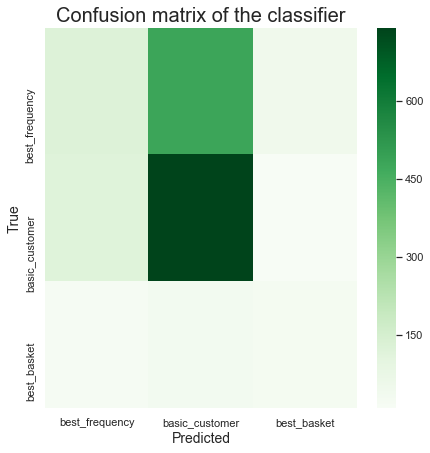

In [57]:
print_confusion_matrix(cf)

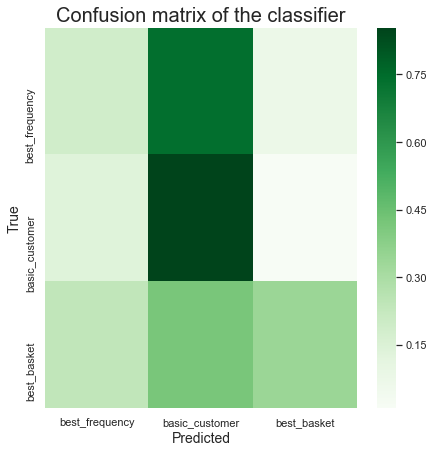

In [58]:
cf_normalised = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
print_confusion_matrix(cf_normalised)

In [59]:
from sklearn.metrics import classification_report

target_names = ['best_frequency', 'basic_customer', 'best_basket']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

best_frequency       0.47      0.19      0.27       652
basic_customer       0.59      0.85      0.70       868
   best_basket       0.32      0.34      0.33        76

     micro avg       0.56      0.56      0.56      1596
     macro avg       0.46      0.46      0.43      1596
  weighted avg       0.53      0.56      0.51      1596

